# Class Imbalance : Resampling

---

비즈니스 상황에서 타겟 클래스의 불균형은 굉장히 흔한 현상
> * 고객 이탈 예측 : 잔존 > 이탈
* 금융 비정상 거래 예측 : 정상 > 비정상(사기거래)
* 제조 공정간 불량 예측 : 정상 > 불량


* 이번 단원에서는 Class Imbalance 상황에 대해서 살펴보는 것을 중점으로 둡니다.
* 그래서, train과 validation 혹은 test 구분 하지 않고 진행합니다.

## 1.환경 준비

### 1) 라이브러리

In [1]:
# 기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification

### 2) 데이터만들기

In [2]:
seed = 28

x, y = make_classification(n_samples=1000,
                        n_features=2, 
                        n_redundant=0, 
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1, 
                        random_state=seed)

### 3) 필요한 함수 만들기

* 데이터 분포 시각화 함수

In [3]:
def my_scatter(x, y) :

    # y가 넘파이 이므로 시리즈로 변환하고 클래스별 갯수 세기
    temp = pd.Series(y).value_counts()

    plt.figure(figsize=(6, 6))
    plt.title(f'0 : {temp[0]},    1 : {temp[1]}')

    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)

    plt.xlabel('x1')
    plt.ylabel('x2')
    # plt.xlim(-4, 2.2)
    # plt.ylim(-4, 2.2)
    plt.show()

* svm 모델 시각화
    * 아래 모델은 **feauture 수가 2개일 때만 가능**합니다.
    * 모델 두개를 비교 가능.

In [4]:
def svm_visualize(x, y, model1, model2 = 0) :

    xx, yy = np.meshgrid(np.linspace(x[:,0].min(), x[:,0].max(), 50), 
                         np.linspace(x[:,1].min(), x[:,1].max(), 50)) # mesh grid

    # 메쉬 그리드값에 대해 모델 부터 거리 값 만들기.
    Z = model1.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    if model2 != 0 : # 두번째 모델이 있으면 처리
        Z1 = model2.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z1 = Z1.reshape(xx.shape)

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y)
    plt.contour(xx, yy, Z, levels=[0], colors = 'gray',linestyles  = '--')

    if model2 != 0 : # 두번째 모델이 있으면 처리
        plt.contour(xx, yy, Z1, levels=[0], colors = 'r',linestyles  = '--')

    plt.axis("tight")
    plt.show()

- 위에서 만든 데이터 분포를 확인합니다.

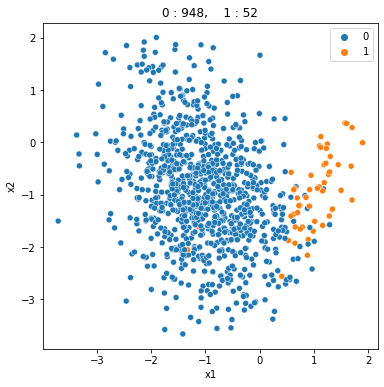

In [5]:
my_scatter(x, y)

## 2.불균형 데이터 그대로 사용하기

### 1) 데이터 둘러보기

0    948
1     52
dtype: int64


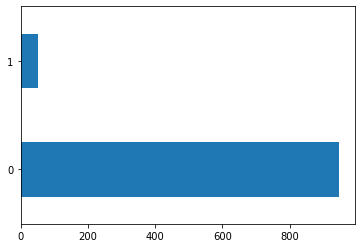

In [6]:
# class imbalance
print(pd.Series(y).value_counts())

pd.Series(y).value_counts().plot(kind = 'barh')
plt.show()

### 2) 그대로 모델링 수행

In [7]:
from sklearn.svm import SVC
from sklearn.metrics import *

In [8]:
# 모델링 및 평가
model = SVC(kernel='linear')
model.fit(x, y)
pred = model.predict(x)

print(confusion_matrix(y, pred))
print('=' * 55)
print(classification_report(y, pred))

[[940   8]
 [ 19  33]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       948
           1       0.80      0.63      0.71        52

    accuracy                           0.97      1000
   macro avg       0.89      0.81      0.85      1000
weighted avg       0.97      0.97      0.97      1000



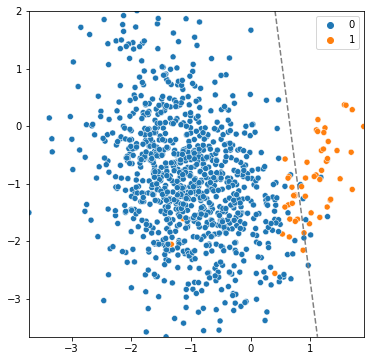

In [9]:
svm_visualize(x,y, model)

## 2.Resampling

In [ ]:
# !pip install imblearn

In [10]:
# 필요한 함수들을 불러옵니다.
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

### 1) Down sampling

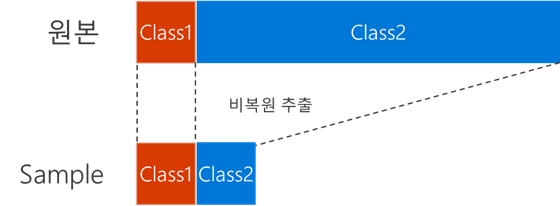

* Down Sampling을 수행하고 데이터 분포를 비교해 봅시다.

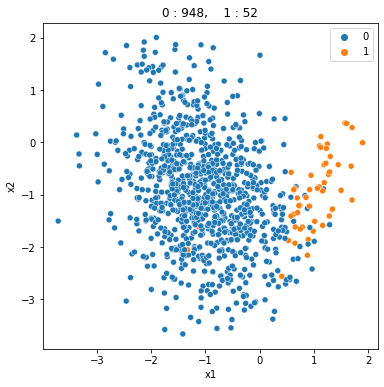

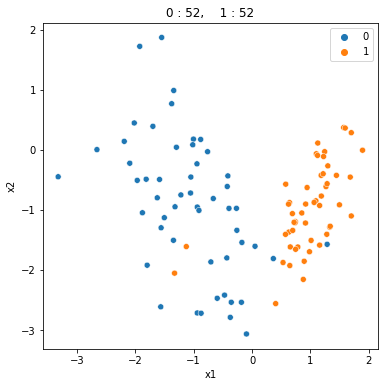

In [11]:
# Down sampling : 적은 쪽 클래스는 그대로, 많은 쪽 클래스는 랜덤 샘플링(적은쪽 클래수 수 만큼)
rus = RandomUnderSampler(random_state = 4)
x_d, y_d = rus.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_d, y_d)

* Down Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

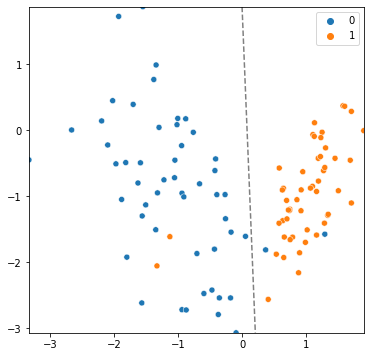

In [12]:
model_d = SVC(kernel='linear')
model_d.fit(x_d,y_d)

svm_visualize(x_d,y_d, model_d)

* 기존 모델과 비교해 봅시다.

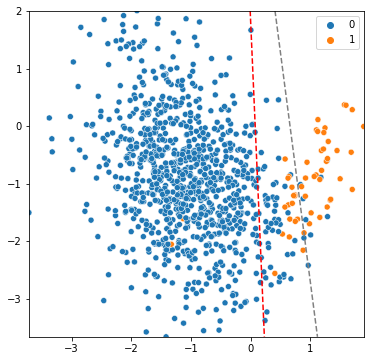

In [13]:
svm_visualize(x,y, model, model_d)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [14]:
# 모델링 및 평가
pred = model_d.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### 2) Up sampling

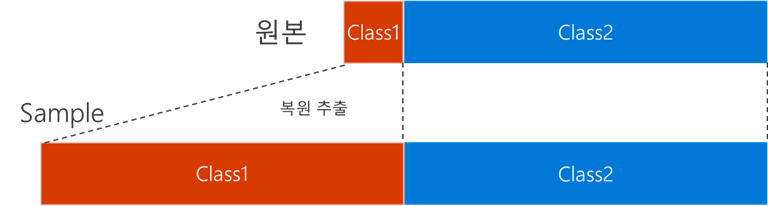

* Up Sampling을 수행하고 데이터 분포를 비교해 봅시다.

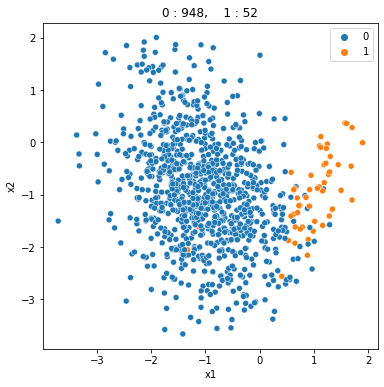

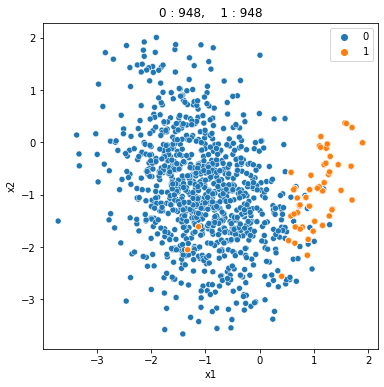

In [15]:
# Up sampling : 많은 클래스는 그대로, 적은 클래스는 랜덤 복원추출(많은 클래스 만큼)
ros = RandomOverSampler(random_state = 4)
x_u, y_u = ros.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_u, y_u)

In [16]:
# 데이터를 열어보면, 클래스 1의 값이 중복으로 추출된 것을 볼수 있습니다.
UpSample = pd.DataFrame(x_u, columns=['x1','x2'])
UpSample['y'] = y_u
UpSample.loc[UpSample['y'] == 1].sort_values('x1')

,x1,x2,y
1675,-1.328629,-2.054089,1
1034,-1.328629,-2.054089,1
1524,-1.328629,-2.054089,1
1375,-1.328629,-2.054089,1
1657,-1.328629,-2.054089,1
...,...,...,...
1789,1.895357,-0.006780,1
1872,1.895357,-0.006780,1
1799,1.895357,-0.006780,1
1883,1.895357,-0.006780,1


In [ ]:
# 랜덤 복원 추출을 하다보니, 모든 값이 동일한 수 만큼 추출된 것이 아니라, 각각 다르게 추출됨
UpSample.loc[UpSample['y'] == 1].value_counts()

* UP Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

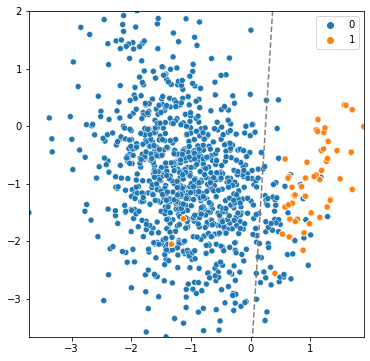

In [18]:
model_u = SVC(kernel='linear')
model_u.fit(x_u,y_u)

svm_visualize(x_u,y_u, model_u)

* 기존 모델과 비교해 봅시다.

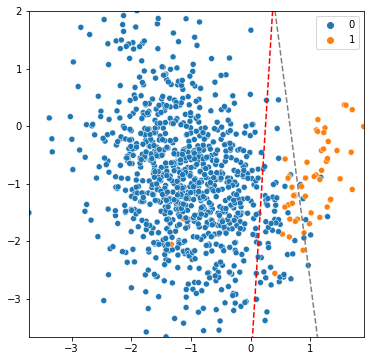

In [19]:
svm_visualize(x,y, model, model_u)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [20]:
# 모델링 및 평가
pred = model_u.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[888  60]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.45      0.96      0.62        52

    accuracy                           0.94      1000
   macro avg       0.73      0.95      0.79      1000
weighted avg       0.97      0.94      0.95      1000



### 3) SMOTE(**S**ynthetic **M**inority **O**versampling **TE**chnique)

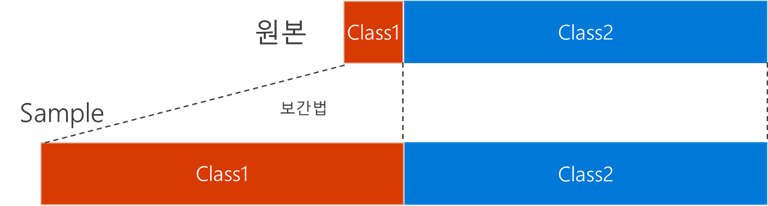

* SMOTE Sampling을 수행하고 데이터 분포를 비교해 봅시다.

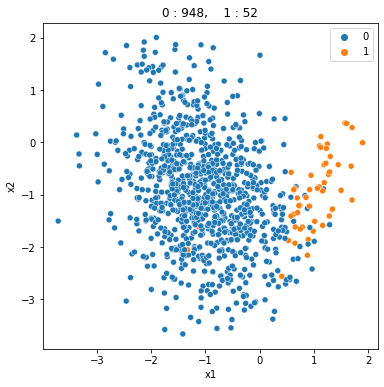

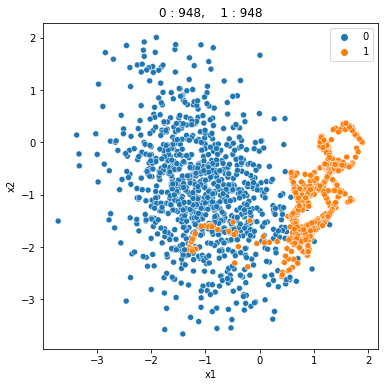

In [21]:
# SMOTE : 많은쪽은 그대로(혹은 약간 down sampling), 적은쪽은 보간법!
smote = SMOTE(random_state = 4) # k_neighbors의미 확인
x_sm, y_sm = smote.fit_resample(x, y)

my_scatter(x, y)
my_scatter(x_sm, y_sm)

In [ ]:
# 데이터를 열어보면 값들이 보간법으로 생성된 것을 볼수 있다.
SMOTESample = pd.DataFrame(x_sm.copy(), columns=['x1','x2'])
SMOTESample['y'] = y_sm
SMOTESample.loc[SMOTESample['y'] == 1].sort_values('x1')

* SMOTE Sampling 데이터셋으로 학습하고 모델을 시각화 해 봅시다.

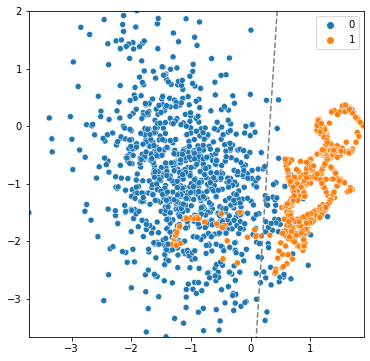

In [22]:
model_sm = SVC(kernel='linear')
model_sm.fit(x_sm,y_sm)

svm_visualize(x_sm,y_sm, model_sm)

* 기존 모델과 비교해 봅시다.

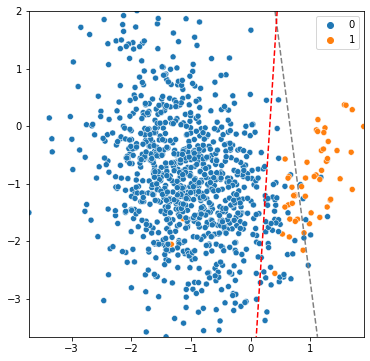

In [23]:
svm_visualize(x,y, model, model_sm)

* 기존 데이터를 가지고 예측하고 평가해 봅시다.

In [24]:
# 모델링 및 평가
pred = model_sm.predict(x)

print(confusion_matrix(y, pred))
print('=' * 60)
print(classification_report(y, pred))

[[895  53]
 [  2  50]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97       948
           1       0.49      0.96      0.65        52

    accuracy                           0.94      1000
   macro avg       0.74      0.95      0.81      1000
weighted avg       0.97      0.94      0.95      1000



## 3.실습 ①

* 새로운 데이터를 생성하시오.
    * seed 값을 조절하여 적절한 데이터를 생성합니다.
* 모델1 : 데이터 그대로 SVC(kernel = 'linear') 모델링을 수행합니다.
    * x, y로 모델링
    * 모델 시각화
    * x로 예측하고, 평가해보기
* 모델2 : Resampling 기법중 하나를 선정하고, 모델링을 수행합니다.
    * resampling x, y로 모델링
    * 모델 시각화 : 모델1, 모델2 비교
    * x로 예측하고, 평가해보기

### 1) 데이터 만들기

* 새로운 데이터를 생성하시오.
    * seed 값을 조절하여 적절한 데이터를 생성합니다.

In [ ]:
seed = 

x, y = make_classification(n_samples=1000,
                        n_features=2, 
                        n_redundant=0, 
                        weights = [0.95, 0.05],  # class 0과 1의 비율 조정 ==> class imbalance 상황만들기
                        n_clusters_per_class=1, 
                        random_state=seed)

my_scatter(x,y)

### 2) 모델1 : 불균형데이터

* 모델1 : 데이터 그대로 SVC(kernel = 'linear') 모델링을 수행합니다.
    * x, y로 모델링
    * 모델 시각화
    * x로 예측하고, 평가해보기

### 3) 모델2 : Resampling
* 모델2 : Resampling 기법중 하나를 선정하고, 모델링을 수행합니다.
    * resampling x, y로 모델링
    * 모델 시각화 : 모델1, 모델2 비교
    * x로 예측하고, 평가해보기

## 4.실습② : Semiconductor manufacturing process dataset


![](https://assets.pandaily.com/uploads/2021/10/semiconductor.png)

* 반도체 제조 공정은 시점별로 수많은 센서로부터 정보를 수집하여 공정을 감시합니다. 
* 센서정보와 함께 공정간 발생된 불량품에 대한 정보를 저장하였습니다.
* 불량을 예측해 봅시다.

### 1) 데이터 준비

* 데이터 로딩

In [25]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


변수 정보 
* label : 1 - 불량, 0 - 정상
* v### : 센서값들


In [26]:
target = 'label'

In [27]:
data[target].value_counts() / data.shape[0]

0    0.933631
1    0.066369
Name: label, dtype: float64

* x, y로 나누기 

In [28]:
x = data.drop(target, axis = 1)
y = data.loc[:, target]

* 가변수화 Dummy Variable  
모두 숫자 데이터이므로 가변수화 대상은 없습니다.


* 데이터 분할
    * 이미 test set은 분할되어 있다고 가정합니다.
    * 주어진 데이터를 train set : validation set 으로 분할

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
# train_val에서 train : val = 8 : 2
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2022)

In [31]:
print(x_train.shape, x_val.shape)

(1253, 52) (314, 52)


### 2) 기본모델링
> * 알고리즘은 로지스틱 회귀를 이용합시다.
* 데이터셋을 그대로 모델링을 수행하시오.
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import * 
import warnings
warnings.simplefilter(action='ignore')

In [33]:
model = LogisticRegression()
model.fit(x_train, y_train)

pred = model.predict(x_val)
print(confusion_matrix(y_val,pred))
print(classification_report(y_val, pred))

[[295   1]
 [ 18   0]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       296
           1       0.00      0.00      0.00        18

    accuracy                           0.94       314
   macro avg       0.47      0.50      0.48       314
weighted avg       0.89      0.94      0.91       314



### 3) 모델링 with Resampling
> * down, up, smote 샘플링후 각각 데이터를 이용하여 모델링 하시오.
* 알고리즘 : 기존 샘플과 비교를 위해서 기본모델링에 사용한 알고리즘 사용
* validate set으로 예측하고 평가(classification report, f1 score)해 봅시다.


In [34]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [35]:
# down sampling
down_sampler = RandomUnderSampler()
d_x_train, d_y_train = down_sampler.fit_resample(x_train, y_train)

In [36]:
# up sampling
up_sampler = RandomOverSampler()
u_x_train, u_y_train = up_sampler.fit_resample(x_train, y_train)

In [37]:
# SMOTE
smote = SMOTE()
s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

* 모델링

In [38]:
model_d = LogisticRegression(solver = 'liblinear')
model_d.fit(d_x_train, d_y_train)
pred_d = model_d.predict(x_val)

print(f1_score(y_val,pred_d, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_d))
print('-' * 55)
print(classification_report(y_val, pred_d))

0.13756613756613756
-------------------------------------------------------
[[138 158]
 [  5  13]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.47      0.63       296
           1       0.08      0.72      0.14        18

    accuracy                           0.48       314
   macro avg       0.52      0.59      0.38       314
weighted avg       0.91      0.48      0.60       314



In [39]:
model_u = LogisticRegression(solver = 'liblinear')
model_u.fit(u_x_train, u_y_train)
pred_u = model_u.predict(x_val)

print(f1_score(y_val,pred_u, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_u))
print('-' * 55)
print(classification_report(y_val, pred_u))

0.14285714285714285
-------------------------------------------------------
[[184 112]
 [  8  10]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.62      0.75       296
           1       0.08      0.56      0.14        18

    accuracy                           0.62       314
   macro avg       0.52      0.59      0.45       314
weighted avg       0.91      0.62      0.72       314



In [44]:
model_s = LogisticRegression(solver = 'liblinear')
model_s.fit(s_x_train, s_y_train)
pred_s = model_s.predict(x_val)

print(f1_score(y_val,pred_s, pos_label=1))
print('-' * 55)
print(confusion_matrix(y_val, pred_s))
print('-' * 55)
print(classification_report(y_val, pred_s))

0.14102564102564102
-------------------------------------------------------
[[337 247]
 [ 21  22]]
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.58      0.72       584
           1       0.08      0.51      0.14        43

    accuracy                           0.57       627
   macro avg       0.51      0.54      0.43       627
weighted avg       0.88      0.57      0.68       627



### 4) [추가] 로지스틱 회귀 - 여러번 반복 실행

* 다음 절차를 반복적으로 수행한 후 결과를 저장합시다.
    * train_test_split
    * down sampling, up sampling ,smote 로 각각 데이터 저장
    * 각각의 샘플을 이용하여 로지스틱 회귀 모델 생성
    * 각 모델의 예측 및 f1 score 결과를 저장(down, up, smote 샘플로 만든 모델의 예측 결과를 각각의 리스트 등에 저장)
* 반복 수행 후 저장된 f1 score를 density plot(sns.kdeplot() 등) 으로 그래프로 그려 비교해 봅시다.

In [41]:
def lr_modeling(x_train, y_train, x_val, y_val) :
    m = LogisticRegression(solver = 'liblinear')
    m.fit(x_train, y_train)
    pred = m.predict(x_val)
    return f1_score(y_val,pred, pos_label=1)

In [ ]:
result_d, result_u, result_s = [], [], []

for i in range(50):
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .4)
    d_x_train, d_y_train = down_sampler.fit_resample(x_train, y_train)
    u_x_train, u_y_train = up_sampler.fit_resample(x_train, y_train)
    s_x_train, s_y_train = smote.fit_resample(x_train, y_train)

    result_d.append(lr_modeling(d_x_train, d_y_train, x_val, y_val))
    result_u.append(lr_modeling(u_x_train, u_y_train, x_val, y_val))
    result_s.append(lr_modeling(s_x_train, s_y_train, x_val, y_val))
    print(i)

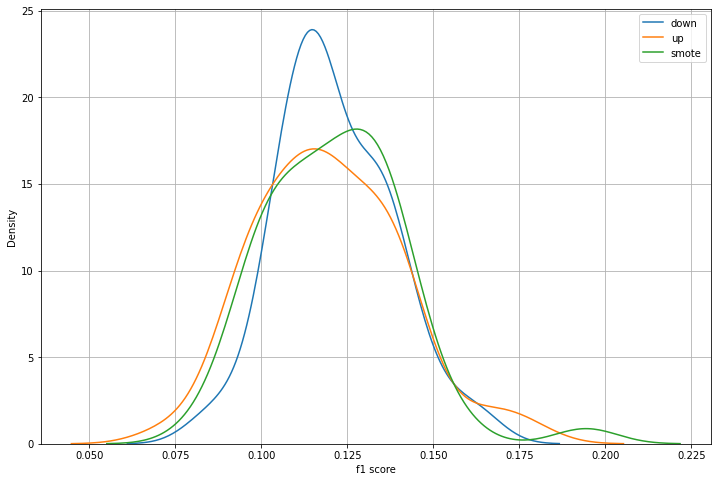

In [43]:
# 그래프로 비교
plt.figure(figsize=(12, 8))
sns.kdeplot(result_d, label= 'down')
sns.kdeplot(result_u, label = 'up')
sns.kdeplot(result_s, label = 'smote' )

plt.xlabel('f1 score')
plt.legend()
plt.grid()
plt.show()
